### **Load libraries**

In [88]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [8]:
rets = pd.read_csv('selected_stocks_rets.csv', index_col=0)
stocks = pd.read_csv('selected_stocks_stocks.csv', index_col=0)

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [9]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [10]:
# Define start and end dates of the analysis
days_of_analysis = 365*5   # 5 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [11]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

### **Preprocessing - Analysis of stationarity**

In [13]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level EXITO.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level GEB.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level GRUBOLIVAR.CL series: 0.0
Augmented Dickey F

In [14]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-8].copy()
val_rets = rets.iloc[-8:].copy()

### **Initial examination**

In [15]:
# Identify stock pairs with very high correlation

# Generate correlation matrix
corr_mat = train_rets.corr()
# Generate a mask to exclude  duplicated pairs
#mask = np.triu(np.ones_like(corr_mat))
#corr_mat = corr_mat*mask
# Convert the matrix into a dataframe structured as a list of pairs with their respective correlations
stack_corr = pd.DataFrame(corr_mat.stack())
stack_corr = stack_corr[stack_corr[0] < 1]
stack_corr = stack_corr[stack_corr[0] != 0]
stack_corr.index.names = ['Stock 1', 'Stock 2']
stack_corr.reset_index(inplace=True)
#(abs(stack_corr[0]) > .7).sum()

# Filter to visualize only the pairs with very high correlations
high_corrs = stack_corr[stack_corr[0] >= 0.8].sort_values(by=0, ascending=False)
high_corrs

,Stock 1,Stock 2,0
19,BCOLOMBIA.CL,PFBCOLOM.CL,0.884756
840,PFBCOLOM.CL,BCOLOMBIA.CL,0.884756
649,ICOLCAP.CL,PFBCOLOM.CL,0.826726
855,PFBCOLOM.CL,ICOLCAP.CL,0.826726
602,HCOLSEL.CL,ICOLCAP.CL,0.826358
644,ICOLCAP.CL,HCOLSEL.CL,0.826358


In [16]:
# Explore how some of these variables correlate with the first lag of other variables
correlations = rk.corr_vars_vs_lags(train_rets, n_lags=20)

In [17]:
(correlations['PFGRUPSURA.CL'].iloc[1].sort_values(ascending=True)
)

PFGRUPSURA.CL   -0.211403
VOO             -0.162224
GRUPOSURA.CL    -0.161166
GE              -0.137652
NKE             -0.119569
F               -0.116158
CENCOSUD.SN     -0.114107
EIMI.L          -0.112496
ICOLCAP.CL      -0.109895
MINEROS.CL      -0.109016
AAPL            -0.108580
FALABELLA.SN    -0.099728
GRUPOAVAL.CL    -0.098490
HCOLSEL.CL      -0.096592
EXITO.CL        -0.089434
PFAVAL.CL       -0.086387
GRUBOLIVAR.CL   -0.084467
BOGOTA.CL       -0.076617
PFGRUPOARG.CL   -0.071740
GRUPOARGOS.CL   -0.069333
LQDA            -0.066947
META            -0.064949
UBER            -0.061798
PFDAVVNDA.CL    -0.059058
BCOLOMBIA.CL    -0.055488
JNJ             -0.046460
SGLD.L          -0.037378
BRK-B           -0.035957
CORFICOLCF.CL   -0.035947
ECOPETROL.CL    -0.033060
ENKA.CL         -0.026951
BVC.CL          -0.024340
TERPEL.CL       -0.017485
CELSIA.CL       -0.000866
PFBCOLOM.CL      0.003839
NUTRESA.CL       0.009397
PFCORFICOL.CL    0.014760
CHILE.SN         0.018760
ISA.CL      

In [13]:
# Identify the stocks with the highest and lowest average correlation with the 1st lag of other stocks
mean_correlations_1st_lag = {}
for var in correlations:
    mean_correlations_1st_lag[var] = abs(correlations[var].iloc[1:5]).mean().mean()
mean_correlations_1st_lag = pd.Series(mean_correlations_1st_lag).sort_values(ascending=False)
mean_correlations_1st_lag

HCOLSEL.CL       0.053064
ICOLCAP.CL       0.049883
BOGOTA.CL        0.045670
PFCORFICOL.CL    0.041386
PROMIGAS.CL      0.040475
PFDAVVNDA.CL     0.038273
GRUPOSURA.CL     0.037743
BHI.CL           0.036890
CORFICOLCF.CL    0.036151
PFGRUPSURA.CL    0.036105
PFAVAL.CL        0.035765
MINEROS.CL       0.035613
PFBCOLOM.CL      0.035604
GRUBOLIVAR.CL    0.035485
EXITO.CL         0.035304
SUAS.CL          0.035259
GRUPOAVAL.CL     0.034563
ISAC.CL          0.034547
BVC.CL           0.034439
CELSIA.CL        0.034056
BCOLOMBIA.CL     0.033333
SDHA.CL          0.033212
GRUPOARGOS.CL    0.032906
CHILE.SN         0.032759
CNEC.CL          0.032650
GEB.CL           0.032576
NUTRESA.CL       0.031885
PFGRUPOARG.CL    0.031733
CENCOSUD.SN      0.031520
UBER             0.031327
TERPEL.CL        0.031254
PFE              0.030576
FALABELLA.SN     0.030542
ISA.CL           0.029878
NKE              0.028943
JPEA.CL          0.028870
JNJ              0.028160
BRK-B            0.028058
F           

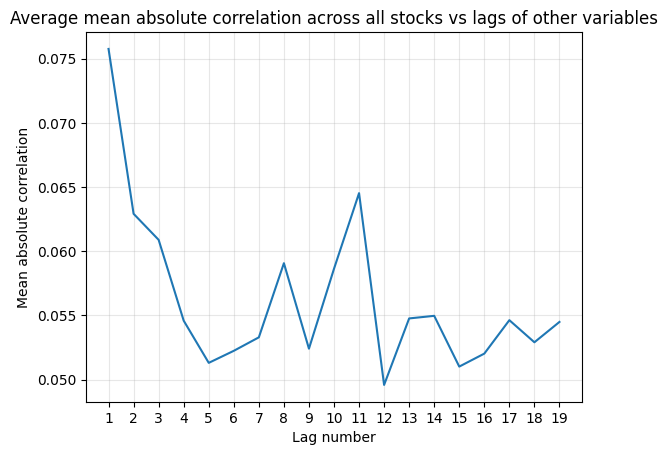

In [18]:
# Identify the number of lags that suggest relevant information across all variables
mean_lags = []
for lag in range(20):
    mean_correlations_n_lag = {}
    for var in correlations:
        mean_correlations_n_lag[var] = abs(correlations[var].iloc[lag]).mean().mean()
    mean_lags.append(pd.Series(mean_correlations_n_lag))
mean_lags = pd.concat(mean_lags, axis=1).mean(0)

# Visualize the results
mean_lags.iloc[1:].plot()
plt.grid(alpha=.3)
plt.title('Average mean absolute correlation across all stocks vs lags of other variables')
plt.ylabel('Mean absolute correlation')
plt.xlabel('Lag number')
plt.xticks(np.arange(1, 20))
plt.show()

In [19]:
# Choose the variables with highest absolute correlation with lags 1-11 of other variables
mean_correlations_n_lag = {}
for var in correlations:
    mean_correlations_n_lag[var] = abs(correlations[var].iloc[:12]).mean().mean()
mean_correlations_n_lag = pd.Series(mean_correlations_n_lag).sort_values(ascending=False)
mean_correlations_n_lag

BCOLOMBIA.CL     0.094035
ICOLCAP.CL       0.093464
PFBCOLOM.CL      0.093017
F                0.089972
PFDAVVNDA.CL     0.087273
ECOPETROL.CL     0.087212
GRUPOARGOS.CL    0.087046
VOO              0.086124
PFGRUPOARG.CL    0.084420
GE               0.083042
PFAVAL.CL        0.082251
BRK-B            0.081460
PFGRUPSURA.CL    0.080738
EIMI.L           0.079192
UBER             0.079111
HCOLSEL.CL       0.078941
FALABELLA.SN     0.077889
GRUPOSURA.CL     0.076058
NKE              0.075198
PFCORFICOL.CL    0.073406
CORFICOLCF.CL    0.072557
TERPEL.CL        0.072003
CELSIA.CL        0.070497
CHILE.SN         0.070433
ISA.CL           0.070285
META             0.070131
MINEROS.CL       0.069146
GRUPOAVAL.CL     0.066271
BOGOTA.CL        0.066189
AAPL             0.065766
JNJ              0.065531
GRUBOLIVAR.CL    0.064736
EXITO.CL         0.062823
SGLD.L           0.062669
CENCOSUD.SN      0.062411
BVC.CL           0.061011
GEB.CL           0.060716
LQDA             0.059994
NUTRESA.CL  

### **VAR bagging**

In [20]:
start_value = train_rets.iloc[0].copy()
train_rets_integrated = (train_rets - train_rets.shift(1)).dropna()

In [208]:
symbols_list = list(train_rets.columns.values) # List of all available stock symbols
n_iterations = 1000 # The number of iterations of VAR models to perform
set_size = 10 # Number of symbols modeled in each iteration
periods_to_forecast = 8 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [153]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    subset_df = train_rets_integrated[symbols_selection]
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(10)
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 7
Iteration 1 finished
Iteration 1, ideal_n_lags: 5
Iteration 2 finished
Iteration 2, ideal_n_lags: 4
Iteration 3 finished
Iteration 3, ideal_n_lags: 6
Iteration 4 finished
Iteration 4, ideal_n_lags: 4
Iteration 5 finished
Iteration 5, ideal_n_lags: 4
Iteration 6 finished
Iteration 6, ideal_n_lags: 9
Iteration 7 finished
Iteration 7, ideal_n_lags: 4
Iteration 8 finished
Iteration 8, ideal_n_lags: 7
Iteration 9 finished
Iteration 9, ideal_n_lags: 8
Iteration 10 finished
Iteration 10, ideal_n_lags: 6
Iteration 11 finished
Iteration 11, ideal_n_lags: 6
Iteration 12 finished
Iteration 12, ideal_n_lags: 5
Iteration 13 finished
Iteration 13, ideal_n_lags: 10
Iteration 14 finished
Iteration 14, ideal_n_lags: 4
Iteration 15 finished
Iteration 15, ideal_n_lags: 6
Iteration 16 finished
Iteration 16, ideal_n_lags: 7
Iteration 17 finished
Iteration 17, ideal_n_lags: 8
Iteration 18 finished
Iteration 18, ideal_n_lags: 7
Iteration 19 finished
Iteration 19, ideal_n_lags: 8


In [154]:
import warnings
warnings.filterwarnings('ignore')

prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    pred_df = pd.DataFrame(prediction_results[symbol])
    pred_series = pred_df.mean(axis=1)
    pred_series = train_rets[symbol][-1] + pred_series.cumsum()
    pred_series.index = val_rets.index
    #pred_series = rk.invert_transformation(train_rets[symbol][-1], pred_series)
    prediction_results_processed[symbol] = pred_series

In [307]:
symbol = 'AAPL'
prediction_results_processed[symbol]

Date
2025-01-13/2025-01-19   -0.009193
2025-01-20/2025-01-26   -0.005387
2025-01-27/2025-02-02    0.003211
2025-02-03/2025-02-09    0.001326
2025-02-10/2025-02-16   -0.008302
2025-02-17/2025-02-23   -0.013283
2025-02-24/2025-03-02   -0.005090
2025-03-03/2025-03-09   -0.009881
Freq: W-SUN, dtype: float64

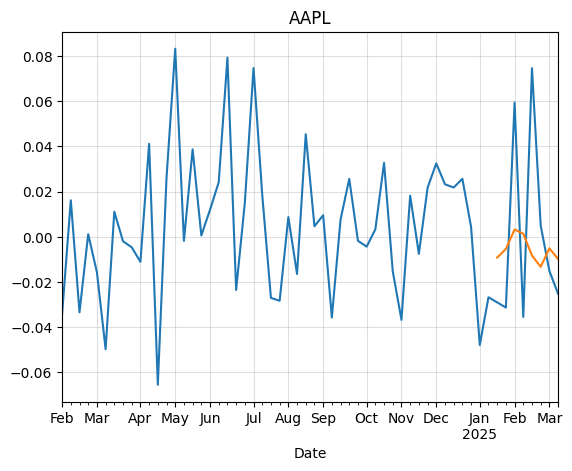

In [308]:
pd.concat([train_rets.iloc[-50:][symbol], val_rets[symbol]], axis=0).plot()
prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [312]:
weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])

linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
lambda_ = 0.3
exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()

(exponential_decay_w, linear_decay_w)

(array([0.28504003, 0.21116285, 0.15643328, 0.11588863, 0.08585241,
        0.06360103, 0.0471168 , 0.03490498]),
 array([0.22222222, 0.19444444, 0.16666667, 0.13888889, 0.11111111,
        0.08333333, 0.05555556, 0.02777778]))

In [310]:
predicted_yearly_return = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
linear_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1
exponential_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1
historical_yearly_return = rk.summary_stats(train_rets[[symbol]][-108:], periods_per_year=periods_per_year)['Annualized Return'][0]
actual_yearly_return = ((val_rets[symbol] + 1).prod()**(1/len(val_rets[symbol])))**(periods_per_year) - 1

print(f'{predicted_yearly_return} - Predicted yearly returns')
print(f'{linear_decay_predicted_yearly_return} - Linear decay predicted yearly returns')
print(f'{exponential_decay_predicted_yearly_return} - Exponential decay predicted yearly returns')
print(f'{historical_yearly_return} - Historical yearly returns')
print(f'{actual_yearly_return} - Actual yearly returns')

-0.27110944040057194 - Predicted yearly returns
-0.2353870066697087 - Linear decay predicted yearly returns
-0.2471890360206095 - Exponential decay predicted yearly returns
0.33392376086597775 - Historical yearly returns
-0.023998091258844 - Actual yearly returns


In [194]:
train_rets.columns

Index(['BCOLOMBIA.CL', 'BOGOTA.CL', 'BVC.CL', 'CELSIA.CL', 'CNEC.CL',
       'CORFICOLCF.CL', 'ECOPETROL.CL', 'ENKA.CL', 'EXITO.CL', 'GEB.CL',
       'GRUBOLIVAR.CL', 'GRUPOARGOS.CL', 'GRUPOAVAL.CL', 'GRUPOSURA.CL',
       'HCOLSEL.CL', 'ICOLCAP.CL', 'ISA.CL', 'MINEROS.CL', 'NUTRESA.CL',
       'PFAVAL.CL', 'PFBCOLOM.CL', 'PFCORFICOL.CL', 'PFDAVVNDA.CL',
       'PFGRUPOARG.CL', 'PFGRUPSURA.CL', 'TERPEL.CL', 'AAPL', 'BRK-B',
       'CBU7.L', 'CENCOSUD.SN', 'CHILE.SN', 'EIMI.L', 'F', 'FALABELLA.SN',
       'GE', 'JNJ', 'LQDA', 'META', 'NKE', 'PFE', 'SGLD.L', 'UBER', 'VOO'],
      dtype='object')

### **Estimate parameters for the VAR model**

In [124]:
symbols_selected = random.sample(list(train_rets.columns), 10)

In [125]:
symbols_selected

['PFGRUPSURA.CL',
 'F',
 'AAPL',
 'ENKA.CL',
 'BOGOTA.CL',
 'VOO',
 'GRUPOSURA.CL',
 'PFGRUPOARG.CL',
 'CORFICOLCF.CL',
 'GRUPOAVAL.CL']

In [130]:
# Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
#varmod = VAR(train_rets)
varmod = VAR(train_rets_integrated[symbols_selected])
lag_sel = varmod.select_order(10)
print(lag_sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -56.11      -55.97   4.283e-25      -56.05
1       -59.49     -57.90*   1.465e-26      -58.85
2       -60.65      -57.61   4.586e-27     -59.43*
3       -60.80      -56.32   3.974e-27      -59.00
4       -61.04      -55.11   3.202e-27      -58.65
5       -60.93      -53.56   3.676e-27      -57.96
6       -61.02      -52.20   3.533e-27      -57.47
7      -61.24*      -50.98  3.020e-27*      -57.11
8       -61.10      -49.39   3.811e-27      -56.38
9       -61.11      -47.95   4.286e-27      -55.81
10      -61.01      -46.41   5.518e-27      -55.13
--------------------------------------------------


In [127]:
max_lags = lag_sel.aic

In [131]:
# Results of AIC for multiple VAR estimations suggest that 13 lags contain useful information for the 15 stocks selected
var_model = VAR(train_rets_integrated[symbols_selected]).fit(maxlags=max_lags, trend='c')
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Mar, 2025
Time:                     15:43:25
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -51.0388
Nobs:                     244.000    HQIC:                  -57.1166
Log likelihood:           4716.02    FPE:                3.08917e-27
AIC:                     -61.2150    Det(Omega_mle):     2.40234e-28
--------------------------------------------------------------------
Results for equation PFGRUPSURA.CL
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000051         0.003546            0.015           0.988
L1.PFGRUPSURA.CL        -0.962946         0.108272           -8.894           0.000
L1.F                     0.025301       

In [132]:
# Test for absence of significant residual autocorrelations
test_corr = var_model.test_whiteness(nlags=22, signif=0.05, adjusted=False)
# There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

7.446172117888868e-06

In [133]:
# Check if the VAR model is stable
stest = var_model.is_stable()
# The model is stable if the result is True
stest

True

### **Predictions** 

In [134]:
predictions = var_model.forecast(train_rets_integrated[symbols_selected].values, 8)

In [135]:
predictions_df = pd.DataFrame(data=predictions, columns=symbols_selected, index=val_rets.index)
predictions_df = rk.invert_transformation(train_rets[symbols_selected].iloc[-max_lags-1], predictions_df)

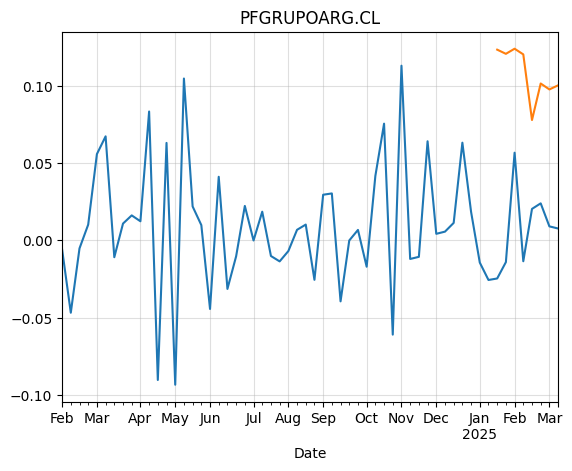

In [148]:
symbol = symbols_selected[7]
pd.concat([train_rets.iloc[-50:][symbol], val_rets.iloc[:][symbol]], axis=0).plot()
predictions_df.iloc[:][symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [ ]:
# Check 'PFGRUPOARG.CL' and 'PFGRUPSURA.CL'